# Natural Language Processing for the Fake News Challenge

## Main Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Set up the data for preprocessing
### Load and sample the data

In [2]:
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = data_folder_name +'/'+ train_body_filename 
train_stance_path = data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

In [3]:
body_data.sample(10)

,Body ID,articleBody
630,956,BAGHDAD — The Islamic State (IS) has been accu...
1462,2202,"The ""Jihadi John"" killer who has featured in s..."
510,761,SYDNEY - An Australian man had a spider remove...
496,738,"Josh Paler Lin, a YouTube star whose channel h..."
58,86,After brutally beating up African youth at a m...
1323,1987,CRAIG WARGA/NY DAILY NEWS/GETTY IMAGES\n\nSo m...
548,825,Defense Secretary Chuck Hagel said on Saturday...
1430,2155,Lebanese authorities are holding a daughter an...
74,115,Afghanistan veteran Sam Arnold uploaded this s...
740,1115,Militants reportedly have three captured jets ...


### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [4]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

# randomly drop rows to improve performance on SVM
remove_n = 0
drop_indices = np.random.choice(total_data.index, remove_n, replace=False)
total_data = total_data.drop(drop_indices)

# add relevance column
total_data['Relevance'] = np.where(total_data['Stance'] == 'unrelated', 'unrelated', 'related')
total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
48845,2483,Offers have been pouring in to re-home a dog f...,It’s About To Get Harder To Be Arrested For Po...,unrelated,unrelated
15926,958,An animal lover from Norfolk splashed hundreds...,Airport worker strips naked at security scanne...,unrelated,unrelated
3110,186,The sound of 10 or 11 shots from the gun of Fe...,Kim Jong-un relying on ‘cobra wine’ after prob...,unrelated,unrelated
47813,2443,There have been reports of predator drones bei...,Research Medical Center denies reports that a ...,unrelated,unrelated
31376,1745,Digital retail company Amazon announced Thursd...,Amazon's first brick-and-mortar store said to ...,discuss,related
42402,2206,"A ""propaganda video"" released by ISIS has set ...",ISIS Video Shows Execution of David Cawthorne ...,agree,related
6603,388,"Nikolai Kryaglyachenko, 12, now attracts coins...",Apple may launch 12-inch MacBook Air with Reti...,unrelated,unrelated
7743,490,One passenger at Dulles International Airport ...,CNN Plays Alleged Audiotape of Michael Brown S...,unrelated,unrelated
9988,615,"""Eh-oh!"" A 19-year-old student is claiming tha...","Etats-Unis: Mort pendant 48 minutes, un prêtre...",unrelated,unrelated
28271,1580,"In a video posted online Tuesday, ISIS beheads...","James Wright Foley, Kidnapped Journalist, Appa...",discuss,related


### Splitting the dataset into train and validation sets

In [5]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values , test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)


,Headline,articleBody
37579,"Spider burrowed into appendix scar, crawled th...",Twitter is abuzz with rumours that Cuba's form...
48945,Pope Francis did not tell boy heaven has room ...,SAN SEVERINO - Go to the hospital accusing a t...
41728,REVEALED: Woman Behind $5 Million Per Year You...,"Longtime ""NBC Nightly News"" anchor Tom Brokaw ..."
38287,Kim Jong-un: obese leader 'fractured both ankles',There's a story currently making the rounds ab...
31605,Nun gives birth to surprise baby after complai...,"Money makes the world go round, right?\n\nLunc..."
49226,BiH: Seven Primary School Students Pregnant Af...,"28 girls, aged 13 and 14, from a small town we..."
16391,"Thanks Uncle Sam, we have your weapons airdrop...",Brian Williams took a moment on Monday’s “NBC ...
9238,Texas Truck Winds Up in Syria With Islamic Mil...,"Ever since his wife Ruby's death in 2003, wido..."
47534,Apple Watch launch expected in late March,Apple has been evaluating platinum for future ...
3610,Report of Kim Jong-un’s ankle injury add fuel ...,We took a look at the photo said to show the b...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [6]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [7]:
# feature extraction with TF-IDF

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=10, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=10, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
train = preprocessor.fit_transform(X_train)
val = preprocessor.transform(X_val)
print('Train size: ', train.shape)
print('Val size: ', val.shape)

Train size:  (39977, 20)
Val size:  (9995, 20)


## Evaluation Metrics

### Confusion Matrix

In [8]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [9]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Training Models

### Naive Bayes

In [10]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train, y_train)
print("train score:", model.score(train, y_train))
print("validation score:", model.score(val, y_val))

train score: 0.7333466743377443
validation score: 0.7231615807903952


### Support Vector Machine Classifier

In [11]:
model = SVC()
model.fit(train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

              precision    recall  f1-score   support

     related       0.77      0.10      0.18      2767
   unrelated       0.74      0.99      0.85      7228

    accuracy                           0.74      9995
   macro avg       0.76      0.55      0.52      9995
weighted avg       0.75      0.74      0.66      9995



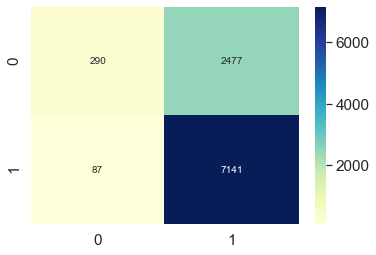

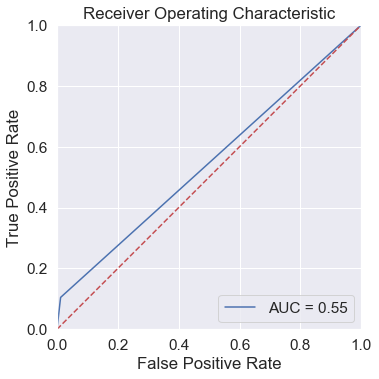

In [12]:
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confussion_matrix(y_val, y_pred)

# convert to 0s and 1s for plotting ROC curve
roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

plot_roc_curve(roc_y_val, roc_y_pred)

In [13]:
# training an SVM on TF-IDF features
# Define the parameters to tune

parameters = {
    'C': [1, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)


              precision    recall  f1-score   support

     related       0.71      0.31      0.43      2767
   unrelated       0.78      0.95      0.86      7228

    accuracy                           0.77      9995
   macro avg       0.74      0.63      0.65      9995
weighted avg       0.76      0.77      0.74      9995



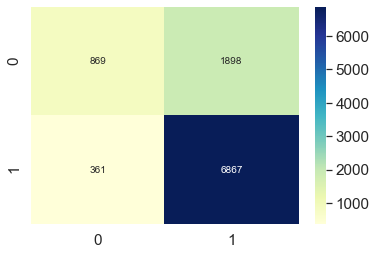

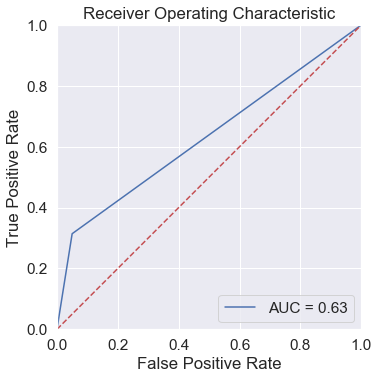

In [14]:
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confussion_matrix(y_val, y_pred)

# convert to 0s and 1s for plotting ROC curve
roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

plot_roc_curve(roc_y_val, roc_y_pred)